In [53]:
import pandas as pd
import numpy as np
import seaborn as sns

In [18]:
!pip install ucimlrepo


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [102]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
## metadata 
#print(adult.metadata) 
#  
## variable information 
#print(adult.variables) 


In [103]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [109]:
y['income'] = y['income'].apply(lambda x: '<=50' if '=' in x else '>50')

C:\Users\user\AppData\Local\Temp\ipykernel_9376\1821361645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['income'] = y['income'].apply(lambda x: '<=50' if '=' in x else '>50')


In [118]:
y.income.unique()

array([0, 1], dtype=int64)

In [115]:
y['income'] = y['income'].map({'<=50': 0, '>50': 1}) 

C:\Users\user\AppData\Local\Temp\ipykernel_9376\2903698306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['income'] = y['income'].map({'<=50': 0, '>50': 1})


Проверим пропущенные значения

In [119]:
print("Кол-во записей в датасете", X.shape[0],'\n')

print('Кол-во nan в данных')
for col in X.columns:
    print(f'{col}', X[col].isna().sum())
print('target', y.income.isna().sum())

Кол-во записей в датасете 48842 

Кол-во nan в данных
age 0
workclass 963
fnlwgt 0
education 0
education-num 0
marital-status 0
occupation 966
relationship 0
race 0
sex 0
capital-gain 0
capital-loss 0
hours-per-week 0
native-country 274
target 0



Выделим колонки с пропущенными значениями

In [120]:
col_with_na = [col for col in X.columns if X[col].hasnans]

In [121]:
col_with_na

['workclass', 'occupation', 'native-country']

Проверим баланс tergeta и выясним его природу

<AxesSubplot:xlabel='income', ylabel='count'>

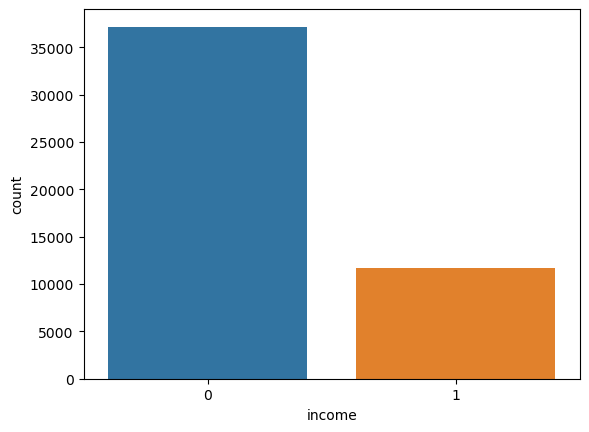

In [122]:
sns.countplot(data=y, x='income')

Можно скоратить мажорный до 20000 и синтезировать минорный класс до 20000

Построим baseline as is и проверим качество

In [145]:
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [124]:
X.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [125]:
categorical = [col for col in X.columns if X[col].dtype=='object']
num = [col for col in X.columns if X[col].dtype=='float64' or X[col].dtype=='int64']


In [134]:
def feature_preporation(df):
    
    preporated = df.copy()
    for col in categorical:
        preporated[col] = preporated[col].astype(str)
    for col in num:
        preporated[col] = preporated[col].astype('float64')
    return preporated

In [135]:
prepared_data = feature_preporation(X)
y['income'] = y['income'].astype('int8') 

C:\Users\user\AppData\Local\Temp\ipykernel_9376\3877028834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['income'] = y['income'].astype('int8')


In [136]:
prepared_data.dtypes

age               float64
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
dtype: object

In [137]:
X_train_val, X_test, y_train_val, y_test = train_test_split(prepared_data, y, test_size=0.12, random_state=17) 

In [138]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.12, random_state=17) 

In [139]:
print('shape train', X_train.shape[0])
print('shape val', X_val.shape[0])
print('shape test', X_test.shape[0])

shape train 37822
shape val 5158
shape test 5862


In [140]:
train_pool = Pool(data=X_train,
                  label=y_train,
                  cat_features=categorical)

val_pool = Pool(data=X_val,
                  label=y_val,
                  cat_features=categorical)


In [ ]:
cat_clf = CatBoostClassifier()

In [177]:
params = {
    'iterations': 1000,
    'depth': 5,
    'loss_function': 'Logloss',
    'task_type': 'CPU',
    'verbose': 100
    
    
}

model_cat = CatBoostClassifier(**params)
model_cat.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=categorical, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077734
0:	learn: 0.6187506	test: 0.6196856	best: 0.6196856 (0)	total: 28.4ms	remaining: 28.4s
100:	learn: 0.2847529	test: 0.2906275	best: 0.2906275 (100)	total: 3.56s	remaining: 31.7s
200:	learn: 0.2720650	test: 0.2809772	best: 0.2808746 (196)	total: 6.99s	remaining: 27.8s
300:	learn: 0.2666183	test: 0.2784371	best: 0.2784131 (288)	total: 10.4s	remaining: 24.3s
400:	learn: 0.2628187	test: 0.2770271	best: 0.2770271 (400)	total: 14s	remaining: 20.9s
500:	learn: 0.2596105	test: 0.2765336	best: 0.2764394 (487)	total: 17.5s	remaining: 17.5s
600:	learn: 0.2560139	test: 0.2757208	best: 0.2756976 (596)	total: 21.1s	remaining: 14s
700:	learn: 0.2531116	test: 0.2750167	best: 0.2749715 (678)	total: 24.8s	remaining: 10.6s
800:	learn: 0.2500836	test: 0.2741422	best: 0.2740624 (793)	total: 28.4s	remaining: 7.05s
900:	learn: 0.2474694	test: 0.2738959	best: 0.2738723 (892)	total: 32s	remaining: 3.52s
999:	learn: 0.2450725	test: 0.2737869	best: 0.2737724 (997)	total: 35.6s	remain

In [169]:
# Получили неплохой baseline постараемся его побить
roc_auc_score(y_test, model_cat.predict_proba(X_test)[:, 1])

0.9323136209563405

In [163]:
predict_true = pd.DataFrame(data=np.c_[y_test, model_cat.predict_proba(X_test)[:, 1]],
                            columns=['label', 'proba'])\
                 .sort_values(by=['proba'], ascending=False)

Сначала разберемся с пропущенными значениями

In [178]:
col_with_na

['workclass', 'occupation', 'native-country']

In [181]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour

import category_encoders as ce

In [182]:
# еще раз проверим nan

def check_missing(data,output_path=None):    
    result = pd.concat([data.isnull().sum(),data.isnull().mean()],axis=1)
    result = result.rename(index=str,columns={0:'total missing',1:'proportion'})
    if output_path is not None:
        result.to_csv('missing.csv')
        print(output_path, 'missing.csv')
    return result

In [183]:
check_missing(X)

,total missing,proportion
age,0,0.000000
workclass,963,0.019717
fnlwgt,0,0.000000
education,0,0.000000
education-num,0,0.000000
marital-status,0,0.000000
occupation,966,0.019778
relationship,0,0.000000
race,0,0.000000
sex,0,0.000000
